## Aplicando Filtros passa-baixa no domínio da frequência

Lembrando que sinais digitais são visto como se estivessem repetidos diversas vezes tanto no domínio espacial quanto no da frequência. Portanto, precisamos preencher os sinais com zeros antes de aplicar a filtragem.

# 1. Leitura da imagem a cálculo da transformada de Fourier

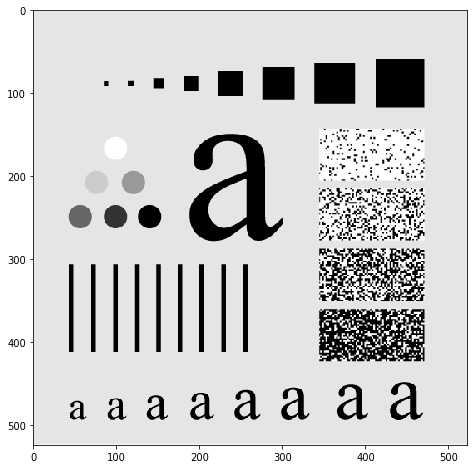

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift

img = plt.imread('test_image.tiff')
plt.figure(figsize=[8,8])
plt.imshow(img, 'gray')

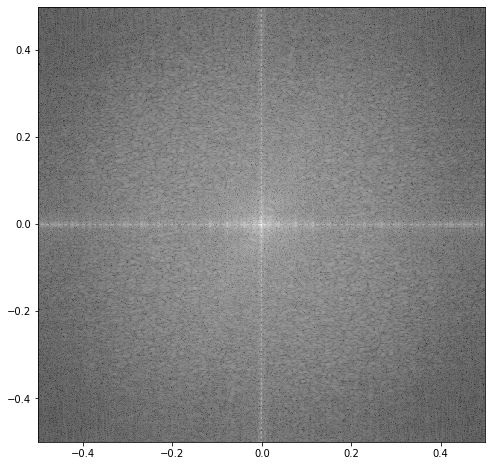

In [2]:
def generate_frequencies(num_rows, num_cols):
    '''Gera frequências do sinal tal que a frequência zero
       esteja no centro dos arrays'''

    freq_r = fftfreq(num_rows)
    freq_c = fftfreq(num_cols)
    freq_r = fftshift(freq_r)
    freq_c = fftshift(freq_c)  

    return freq_r, freq_c

num_rows, num_cols = img.shape
# Adiciona zeros ao final da imagem, para evitar interferência 
# com as diversas cópias (virtuais) da imagem
img_padded = np.pad(img, ((0, num_rows), (0, num_cols)), 
                    mode='constant', constant_values=0)

Fimg = fft2(img_padded)
freq_r, freq_c = generate_frequencies(2*num_rows, 2*num_cols)

Fimg = fftshift(Fimg)
plt.figure(figsize=[8,8])
plt.pcolormesh(freq_c, freq_r, np.log(np.abs(Fimg)), cmap='gray')

# 2. Filtro passa-baixa ideal

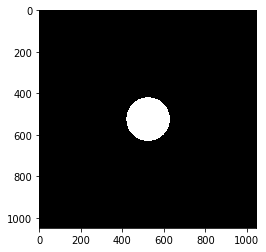

In [3]:
def filtro_passa_baixa(img, radius):
    '''Cria um filtro passa-baixa de mesma dimensão que img. radius define o 
       raio do filtro, isto é, a máxima frequência que será mantida na imagem'''
    num_rows, num_cols = img.shape
    freq_r, freq_c = generate_frequencies(num_rows, num_cols)   
    
    low_pass_filter = np.zeros([num_rows, num_cols])
    for row in range(num_rows):
        for col in range(num_cols):
            distance = np.sqrt(freq_r[row]**2 + freq_c[col]**2)
            if distance<=radius:
                low_pass_filter[row, col] = 1
    return low_pass_filter

lp_filter = filtro_passa_baixa(img_padded, radius=0.1)
plt.imshow(lp_filter, 'gray')

#### Aplicação do filtro

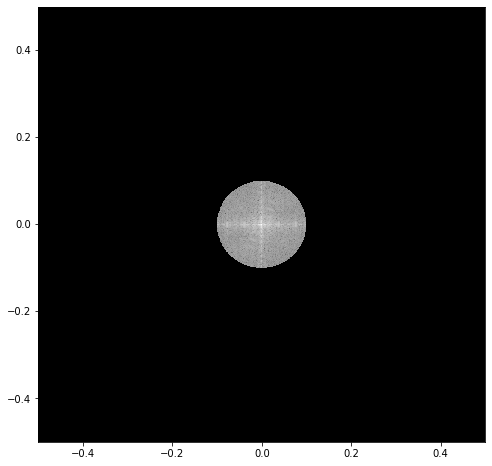

In [4]:
Fimg_filtered = lp_filter*Fimg
plt.figure(figsize=[8,8])
plt.pcolormesh(freq_c, freq_r, np.log(np.abs(Fimg_filtered)+1), cmap='gray')

#### Cálculo da transformada inversa para recuperar a imagem após filtragem

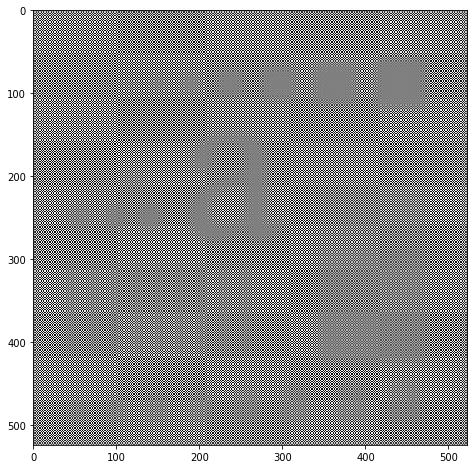

In [9]:
# fftshift é utilizado para retornar o espectro para as posições
# esperadas pela função ifft2
Fimg_filtered = fftshift(Fimg_filtered)
img_filtered = ifft2(Fimg_filtered)
# O resultado da transformada inversa de Fourier possui números complexos
# por causa da precisão finita do computador. Isso não deveria ocorrer.
# Portanto, mantemos apenas a parte real do resultado
img_filtered = np.real(img_filtered)
# Seleciona imagem final no quadrante superior esquerdo
img_filtered = img_filtered[:num_rows, :num_cols]
plt.figure(figsize=[8,8])
plt.imshow(img_filtered, 'gray')

# 3. Filtro passa-baixa gaussiano

O filtro passa-baixa ideal apresenta artefatos causados pelo corte brusco das frequências do sinal. Para evitar tais artefatos podemos definir um filtro que elimina altas frequências de forma mais suave.

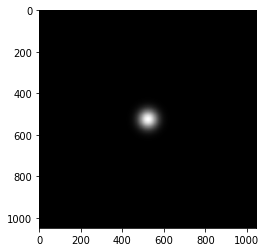

In [6]:
def filtro_passa_baixa_gaussiano(img, sigma_r, sigma_c):
    num_rows, num_cols = img.shape
    freq_r, freq_c = generate_frequencies(num_rows, num_cols)   
    
    low_pass_gauss_filter = np.zeros([num_rows, num_cols])
    for row in range(num_rows):
        for col in range(num_cols):
            exponent = (freq_r[row]**2/(2*sigma_r**2) + 
                    freq_c[col]**2/(2*sigma_c**2))
            low_pass_gauss_filter[row, col] = np.exp(-exponent)
    return low_pass_gauss_filter

lp_filter = filtro_passa_baixa_gaussiano(img_padded, sigma_r=0.03, sigma_c=0.03)
plt.imshow(lp_filter, 'gray')

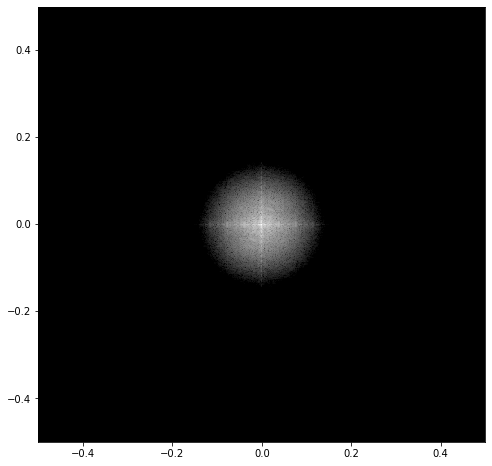

In [7]:
Fimg_filtered = lp_filter*Fimg
plt.figure(figsize=[8,8])
plt.pcolormesh(freq_c, freq_r, np.log(np.abs(Fimg_filtered)), cmap='gray', vmin=0)

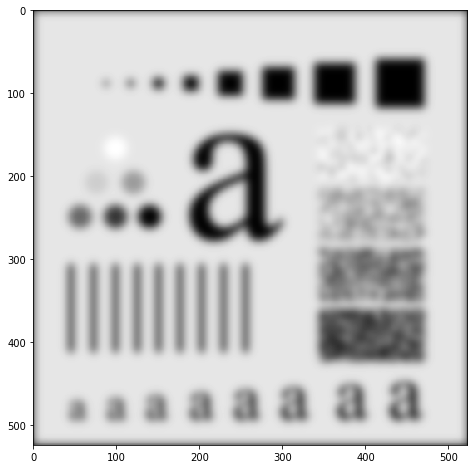

In [8]:
Fimg_filtered = fftshift(Fimg_filtered)
img_filtered = np.real(ifft2(Fimg_filtered))
img_filtered = img_filtered[:num_rows, :num_cols]
plt.figure(figsize=[8,8])
plt.imshow(img_filtered, 'gray')